In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#odczytanie dancyh

titanic_data = pd.read_csv("train.csv")

In [3]:
'''
import seaborn as sb

#zbadanie zależności

sb.heatmap(titanic_data.corr(), cmap="YlGnBu")
plt.show()
'''

'\nimport seaborn as sb\n\n#zbadanie zależności\n\nsb.heatmap(titanic_data.corr(), cmap="YlGnBu")\nplt.show()\n'

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

#podzielenie zbioru na uczący i testujący z równo podzielonymi atrybutami przeżywalności, statusu społecznego, płci
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
  train_set = titanic_data.loc[train_indices]
  test_set = titanic_data.loc[test_indices]

<AxesSubplot:>

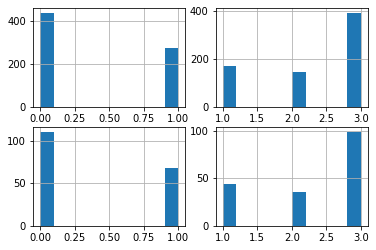

In [5]:
#sprawdzenie czy podzielono właściwie

plt.subplot(2,2,1)
train_set['Survived'].hist()

plt.subplot(2,2,2)
train_set['Pclass'].hist()

plt.subplot(2,2,3)
test_set['Survived'].hist()

plt.subplot(2,2,4)
test_set['Pclass'].hist()

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

#zastąpienie brakujących wartości wieku wartością średnią
class AgeImputer(BaseEstimator, TransformerMixin):

  def fit(self, X, y="none"):
    return self
  
  def transform(self, X):
    imputer = SimpleImputer(strategy="mean")
    X['Age'] = imputer.fit_transform(X[['Age']])
    return X

In [7]:
#zamiana pola Embarked oznaczającego miasto w którym wsiadła dana osoba 
#oraz pola Sex
#z litery na wartości biarne w postaci macierzy (kilka kolumn)

from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
  def fit(self, X, y="none"):
    return self
  
  def transform(self, X, y=None):
    encoder = OneHotEncoder()
    matrix = encoder.fit_transform(X[['Embarked']]).toarray()

    column_names = ["C", "S", "Q", "N"]

    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

    matrix = encoder.fit_transform(X[['Sex']]).toarray()

    columnes_names = ["Female", "Male"]
    
    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]
    
    return X

In [8]:
#usuwanie nieistotnych kolumn lub wczesniej zmodyfikowanych (rozbitych)

class FeatureDropper(BaseEstimator, TransformerMixin):

  def fit(self, X, y="none"):
    return self

  def transform(self, X):
    return X.drop(["PassengerID","Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors = "ignore")

In [9]:
#utworzenie pipelinu z preprocessingiem 

from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [10]:
#preprocessing danych treningowych

train_set = pipeline.fit_transform(train_set)

In [11]:
#normalizacja danych

from sklearn.preprocessing import StandardScaler

#rozdzielenie przygotowanego setu na wejscie i wyjscie
X = train_set.drop(['Survived'], axis= 1)
y = train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
Y_data = y.to_numpy()

In [12]:
def models(X_data, Y_data):
  #regresja logistyczna
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
  log.fit(X_data, Y_data)

  #KNeighbors
  # ilosc sasiadow, metryka, potega
  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski', p=2)
  knn.fit(X_data, Y_data)

  #Support Vector Machine - linear
  #algorytm liczenia, parametr startowy generatora startowego
  from sklearn.svm import SVC
  svc_lin = SVC(kernel = 'linear', random_state = 0)
  svc_lin.fit(X_data, Y_data)

  #Support Vector Machine - RBF
  #algorytm liczenia, parametr startowy generatora startowego
  from sklearn.svm import SVC
  svc_rbf = SVC(kernel = 'rbf', random_state = 0)
  svc_rbf.fit(X_data, Y_data)

  #GaussianNB
  from sklearn.naive_bayes import GaussianNB
  gauss = GaussianNB()
  gauss.fit(X_data, Y_data)

  #Drzewo decyzyjne
  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state =0 )
  tree.fit(X_data, Y_data)

  #Losowy las decyzyjny
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
  forest.fit(X_data, Y_data)

 

  return log, knn, svc_lin, svc_rbf, gauss, tree, forest

In [13]:
model = models(X_data, Y_data)

In [14]:
#dokladnosc modeli na zbiorze uczacym

lr_test_acc = model[0].score(X_data, Y_data)
print('Logistic Regression Acc: ', end="")
print(lr_test_acc)

knn_test_acc = model[1].score(X_data, Y_data)
print('KNeighbors Acc: ',end="")
print(knn_test_acc)

svc_lin_test_acc = model[2].score(X_data, Y_data)
print('SVC - Linear Acc: ',end="")
print(svc_lin_test_acc)

svc_rbf_test_acc = model[3].score(X_data, Y_data)
print('SVC - rbf Acc: ',end="")
print(svc_rbf_test_acc)

gauss_test_acc = model[4].score(X_data, Y_data)
print('Gaussian Acc', end="")
print(gauss_test_acc)

dt_test_acc = model[5].score(X_data, Y_data)
print('Decision Tree Acc: ',end="")
print(dt_test_acc)

rfc_test_acc = model[6].score(X_data,Y_data)
print('Random Forest Acc: ',end="")
print(rfc_test_acc)  


Logistic Regression Acc: 0.7935393258426966
KNeighbors Acc: 0.8721910112359551
SVC - Linear Acc: 0.7865168539325843
SVC - rbf Acc: 0.8539325842696629
Gaussian Acc0.7963483146067416
Decision Tree Acc: 1.0
Random Forest Acc: 0.9831460674157303


In [15]:
#preprocessing danych przeznaczonych do testowania
test_set = pipeline.fit_transform(test_set)

In [16]:
#normalizacja danych testowych

#rozdzielenie danych testowych
X_test = test_set.drop(['Survived'], axis= 1)
Y_test = test_set['Survived']

scaler = StandardScaler()
X_test_data = scaler.fit_transform(X_test)
Y_test_data = Y_test.to_numpy()


In [17]:
#tablice przewidywań dla danych modeli

lr_predictions = model[0].predict(X_test_data)
knn_predictions = model[1].predict(X_test_data)
svc_lin_predictions = model[2].predict(X_test_data)
svc_rfb_predictions = model[3].predict(X_test_data)
gauss_predictions = model[4].predict(X_test_data)
dt_predictions = model[5].predict(X_test_data)
rfc_predictions = model[6].predict(X_test_data)


In [18]:
#Macierz pomyłek 
'''
TP FP
FN TN
'''
from sklearn.metrics import confusion_matrix

lr_cm = confusion_matrix(Y_test_data, lr_predictions)
print("logistic regression:")
print(lr_cm)
print("") 

knn_cm = confusion_matrix(Y_test_data, knn_predictions)
print("KNearest Neighbor:")
print(knn_cm) 
print("") 

svc_lin_cm = confusion_matrix(Y_test_data, svc_lin_predictions)
print("SVC linnear")
print(svc_lin_cm) 
print("") 

svc_rfb_cm = confusion_matrix(Y_test_data, svc_rfb_predictions)
print("SVC RFB")
print(svc_rfb_cm) 
print("") 

gauss_cm = confusion_matrix(Y_test_data, gauss_predictions)
print("GaussNB")
print(gauss_cm)
print("") 

dt_cm = confusion_matrix(Y_test_data, dt_predictions)
print("Decision Tree")
print(dt_cm)
print("") 

rfc_cm = confusion_matrix(Y_test_data, rfc_predictions)
print("Random Forest")
print(rfc_cm)
print("") 


logistic regression:
[[94 17]
 [18 50]]

KNearest Neighbor:
[[96 15]
 [24 44]]

SVC linnear
[[94 17]
 [21 47]]

SVC RFB
[[102   9]
 [ 28  40]]

GaussNB
[[93 18]
 [18 50]]

Decision Tree
[[87 24]
 [19 49]]

Random Forest
[[99 12]
 [19 49]]



In [19]:
#wyliczenie dokladnosci dla zbioru testowego

lr_acc = model[0].score(X_test_data, Y_test_data)
print('Logistic Regression Acc: ',end="") 
print(lr_acc)

knn_acc = model[1].score(X_test_data, Y_test_data)
print('KNeighbors Acc: ',end="")
print(knn_acc)

svc_lin_acc = model[2].score(X_test_data, Y_test_data)
print('SVC - Linear Acc: ',end="") 
print(svc_lin_acc)

svc_rbf_acc = model[3].score(X_test_data, Y_test_data)
print('SVC - rbf Acc: ',end="") 
print(svc_rbf_acc)

gauss_acc = model[4].score(X_test_data, Y_test_data)
print('Gaussian Acc',end="") 
print(gauss_acc)

dt_acc = model[5].score(X_test_data, Y_test_data)
print('Decision Tree Acc: ',end="") 
print(dt_acc)

rfc_acc = model[6].score(X_test_data, Y_test_data)
print('Random Forest Acc: ',end="") 
print(rfc_acc)


Logistic Regression Acc: 0.8044692737430168
KNeighbors Acc: 0.7821229050279329
SVC - Linear Acc: 0.7877094972067039
SVC - rbf Acc: 0.7932960893854749
Gaussian Acc0.7988826815642458
Decision Tree Acc: 0.7597765363128491
Random Forest Acc: 0.8268156424581006


In [20]:
#stworzenie tabeli przechowującej ID pasażera informacje o przeżyciu oraz przewidywanie

result = pd.DataFrame(test_set[['PassengerId','Survived']])
result['LR Prediction'] = lr_predictions
result['KNN Prediction'] = knn_predictions
result['SVC_lin Prediction'] = svc_lin_predictions
result['SVC_rfb Prediction'] = svc_rfb_predictions
result['Gauss Prediction'] = gauss_predictions
result['DT Prediction'] = dt_predictions
result['RFC Prediction'] = rfc_predictions

result = result.sort_values(by='PassengerId', ascending=True)

result = result.reset_index(drop=True)

In [21]:
#result.to_csv('titanic.csv', index = False)
print(result)

     PassengerId  Survived  LR Prediction  KNN Prediction  SVC_lin Prediction  \
0              4         1              1               1                   1   
1              9         1              1               1                   1   
2             13         0              0               0                   0   
3             16         1              0               1                   1   
4             17         0              0               0                   0   
..           ...       ...            ...             ...                 ...   
174          878         0              0               0                   0   
175          879         0              0               0                   0   
176          883         0              1               1                   1   
177          890         1              1               1                   0   
178          891         0              0               0                   0   

     SVC_rfb Prediction  Ga